# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

In [7]:
from PIL import Image
import sys
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

sys.path.append('../static/py/classes/')
print(sys.path)
from quantum_models import QuantumModelsTwoQubits
from visualization import Visualization 


['C:\\Users\\Bryan Rodriguez\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\Bryan Rodriguez\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\Bryan Rodriguez\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\Bryan Rodriguez\\AppData\\Local\\Programs\\Python\\Python312', 'd:\\r_repositorios\\quantum_pinns_applications\\harmonic_oscillator\\env', '', 'd:\\r_repositorios\\quantum_pinns_applications\\harmonic_oscillator\\env\\Lib\\site-packages', 'd:\\r_repositorios\\quantum_pinns_applications\\harmonic_oscillator\\env\\Lib\\site-packages\\win32', 'd:\\r_repositorios\\quantum_pinns_applications\\harmonic_oscillator\\env\\Lib\\site-packages\\win32\\lib', 'd:\\r_repositorios\\quantum_pinns_applications\\harmonic_oscillator\\env\\Lib\\site-packages\\Pythonwin', '../static/py/classes/', '../static/py/classes/']


In [2]:

# Define transversal Classes and Methods

# Analitic solution for Oscillator
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y = exp*2*A*cos
    return y

(500,) (500,)
[(tensor(0., requires_grad=True), tensor(1., requires_grad=True)), (tensor(0.04008016, requires_grad=True), tensor(0.71102225, requires_grad=True)), (tensor(0.08016032, requires_grad=True), tensor(0.06482942, requires_grad=True)), (tensor(0.12024048, requires_grad=True), tensor(-0.52211629, requires_grad=True)), (tensor(0.16032064, requires_grad=True), tensor(-0.72837541, requires_grad=True)), (tensor(0.2004008, requires_grad=True), tensor(-0.49429743, requires_grad=True)), (tensor(0.24048096, requires_grad=True), tensor(-0.01680151, requires_grad=True)), (tensor(0.28056112, requires_grad=True), tensor(0.39941576, requires_grad=True)), (tensor(0.32064128, requires_grad=True), tensor(0.52926768, requires_grad=True)), (tensor(0.36072144, requires_grad=True), tensor(0.34211867, requires_grad=True))]
(10,) (10,)


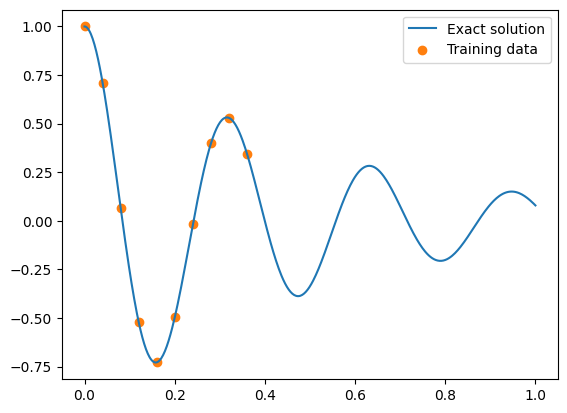

In [3]:
d, w0 = 2, 20

# Get the analytical solution over the full domain
x = np.linspace(0, 1, 500)
y = oscillator(d, w0, x)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
data = list(zip(x_data, y_data))
print(data)
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


## Normal Quantum Neural Network


0.0 1.0
0.04008016032064128 0.7110222474833485
0.08016032064128256 0.06482942206575747
0.12024048096192384 -0.5221162861199296
0.16032064128256512 -0.7283754141116457
0.2004008016032064 -0.4942974344300669
0.24048096192384769 -0.016801508796390478
0.280561122244489 0.39941576221571357
0.32064128256513025 0.5292676786132448
0.3607214428857715 0.34211866981121297
0.0 1.0
0.04008016032064128 0.7110222474833485
0.08016032064128256 0.06482942206575747
0.12024048096192384 -0.5221162861199296
0.16032064128256512 -0.7283754141116457
0.2004008016032064 -0.4942974344300669
0.24048096192384769 -0.016801508796390478
0.280561122244489 0.39941576221571357
0.32064128256513025 0.5292676786132448
0.3607214428857715 0.34211866981121297
0.0 1.0
0.04008016032064128 0.7110222474833485
0.08016032064128256 0.06482942206575747
0.12024048096192384 -0.5221162861199296
0.16032064128256512 -0.7283754141116457
0.2004008016032064 -0.4942974344300669
0.24048096192384769 -0.016801508796390478
0.280561122244489 0.3994

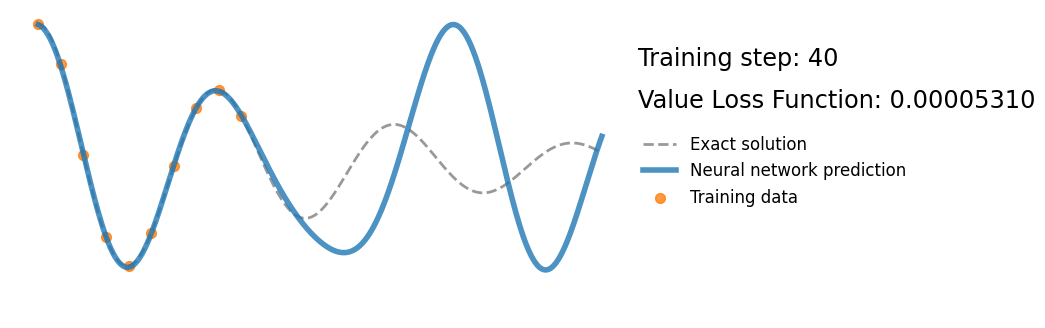

In [6]:
model = QuantumModelsTwoQubits().vqc_four

def average_loss(w):
    losses = 0
    losses_ic = 0
    i = 0
    for x, y in data:
        print(x, y)
        losses += (model(x, w) - y) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (model(x,w)-y)**2
            losses_ic = 0
        i += 1
    return losses/len(data) + losses_ic

gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)


# w = np.array([-1., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
# w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)
w = [-16.96813611,  -8.51338192,   2.6350306,    5.09686365,  -1.774476, -0.67080634,  -6.44371229,  -0.33606813]
# w = 4*np.pi*np.random.rand(8) - 2*np.pi

lr = 1.5
number_epoch = 2000
# optimizacion por método de descenso de gradiente
# for epoch in range(number_epoch):
#    yh =  model(x,w)
#    w = w - lr*gradient_fn_w(w)
#    if (epoch + 1) % 100 == 0:
#        print("epoch", epoch + 1, "loss", average_loss(w))
#        plot_result(epoch+1, x, y, x_data,y_data, yh)
#        clear_output(wait=True)

# Optimización por método de cuasi Newton BFGS


def print_log(w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.12f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(w), weights=w))
    # print('At iterate {iteration:4d},  loss={loss: 3.12f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1

fout = open('../../logs/BFGS_steps_QNN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='BFGS',
                                    jac=gradient_fn_w, callback=print_log, options={'disp': True})

fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
Visualization.plot_result(optimize_losses['nit'], evaluation, x, y, x_data, y_data, yh)


Optimization terminated successfully.
         Current function value: 0.000037
         Iterations: 141
         Function evaluations: 151
         Gradient evaluations: 151
         Hessian evaluations: 141
[-17.81774479  -7.56393179   2.19808435   5.01274829  -3.13666005
  -1.39029391  -5.35097792  -0.09669088]
Solution: f([-17.81774479  -7.56393179   2.19808435   5.01274829  -3.13666005
  -1.39029391  -5.35097792  -0.09669088]) = 0.00004


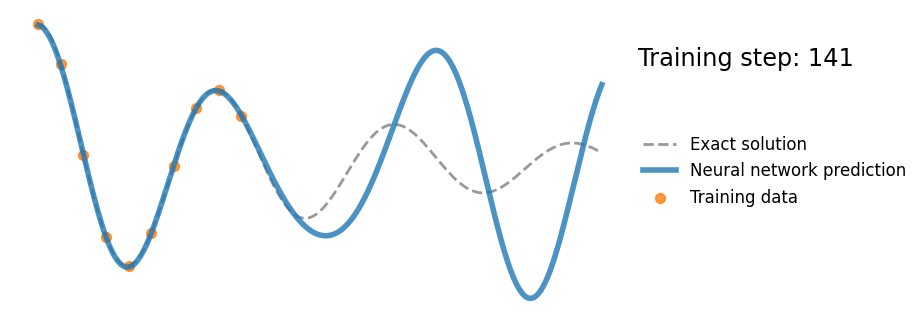

In [5]:
iteration = 1

fout = open('../../../../logs/CG_steps_QNN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='Newton-CG',
                                    jac=gradient_fn_w, hess=hessian_fn_w, callback=print_log, options={'disp': True})

fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
Visualization.plot_result(optimize_losses['nit'], evaluation,x, y, x_data, y_data, yh)


## Physics Informed Quantum Neural Network


Optimization terminated successfully.
         Current function value: 0.020697
         Iterations: 247
         Function evaluations: 283
         Gradient evaluations: 283
[19.50766387  2.87363235  1.28568421 -4.47781954 -5.15714288 -2.14644467
  1.26514719  4.6586626   2.17452399 -2.76653315]
Solution: f([19.50766387  2.87363235  1.28568421 -4.47781954 -5.15714288 -2.14644467
  1.26514719  4.6586626   2.17452399 -2.76653315]) = 0.02070


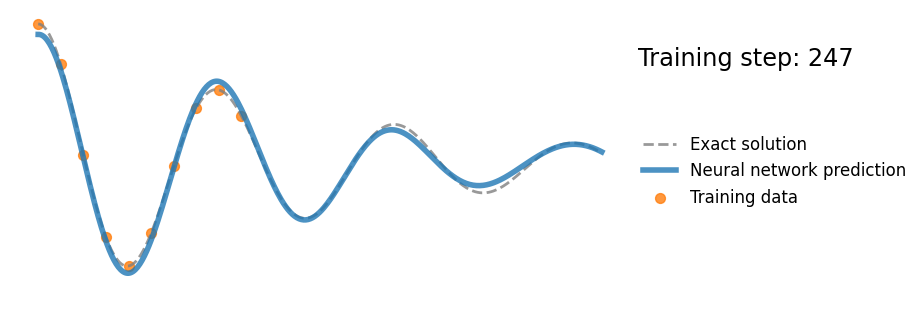

In [6]:
from IPython.display import clear_output
# sample locations over the problem domain
x_physics = np.linspace(0, 1, 30, requires_grad=True)
# x_physics = np.array([-2., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
mu, k = 2*d, w0**2

model = QuantumModelsTwoQubits().vqc_three

def average_loss(w):
    losses = 0
    losses2 = 0
    losses_ic = 0
    dx = qml.grad(model, argnum=0)  # computes dy/dx
    dx2 = qml.grad(dx,  argnum=0)  # computes d^2y/dx^2
    i=0
    for x, y in data:
        losses += (model(x, w) - y) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (model(x,w)-y)**2
            # +(dx(x,w))**2
        i += 1
    
    for x_phy in x_physics:
        yhp = model(x_phy, w)
        # computes the residual of the 1D harmonic oscillator differential equation
        physics = dx2(x_phy, w) + mu*dx(x_phy, w) + k*yhp
        # loss2 = (1e-4)*torch.mean(physics**2)
        losses2 += physics**2
    return losses/len(data) + losses_ic + 1e-4*losses2/len(x_physics)


gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)

# w = np.array([-1., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
# w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)
# w = np.array([0.0, -0.0, 0.0,0.0, 0.0, 0.0], requires_grad = True)
# w = [-31.32352916, 6.97765977, -19.75120469, 0.71892541,  -1., -0.2]
w = [ 2.68042215,  2.92433481,  0.02854919,  1.0318043,  -2.71993564, -1.19001216, 1.87635628,  2.85404538,  3.09725585, -2.47637846] # --> Converge bien Newton CG
# w = 2*np.pi*np.random.rand(10) - np.pi

# lr = 1.5
lr = 2
# Con lr =1e-3 y 1000 epocas se demora 40 minutos
# Optimización por método de cuasi Newton BFGS


def print_log(w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(w), weights=w))
    # print('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1

fout = open('../../../../logs/BFGS_steps_QPINN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='BFGS', jac=gradient_fn_w, callback=print_log, options={'disp': True})
fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
Visualization.plot_result(optimize_losses['nit'], evaluation, x, y, x_data, y_data, yh)


In [ ]:
model = QuantumModelsTwoQubits().vqc_three
w = [ 2.68042215,  2.92433481,  0.02854919,  1.0318043,  -2.71993564, -1.19001216, 1.87635628,  2.85404538,  3.09725585, -2.47637846] # --> Converge bien Newton CG
print(x.shape)
yh_proof = model(x, w)
print(yh_proof.shape)

(500,)
(500,)


In [ ]:
w = [ 2.68042215,  2.92433481,  0.02854919,  1.0318043,  -2.71993564, -1.19001216, 1.87635628,  2.85404538,  3.09725585, -2.47637846] # --> Converge bien Newton CG

iteration = 1

fout = open('../../../../logs/CG_steps_QPINN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='Newton-CG',
                                    jac=gradient_fn_w, hess=hessian_fn_w, callback=print_log, options={'disp': True})

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
Visualization.plot_result(optimize_losses['nit'], evaluation, x, y, x_data, y_data, yh)


KeyboardInterrupt: 